In [496]:
from PIL import Image
import os
from glob import glob
from matplotlib import pyplot as plt
import cv2
import numpy as np

## Get all of the images in the same size so they can all be processed and given the same metrics and get the same effect

In [497]:
def standardize_image(image, target_height=1200, target_width=1800):
    # Get current dimensions
    height, width = image.shape[:2]
    
    # Calculate scaling factors for both dimensions
    height_scale = target_height / height
    width_scale = target_width / width
    
    # Use the smaller scaling factor to maintain aspect ratio
    scale = min(height_scale, width_scale)
    
    # Calculate new dimensions
    new_height = int(height * scale)
    new_width = int(width * scale)
    
    # Resize image
    standardized = cv2.resize(image, (new_width, new_height))
    
    # Create a black canvas of target size
    final_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    #Calculate positioning to center the image
    y_offset = (target_height - new_height) // 2
    x_offset = (target_width - new_width) // 2
    
    # Place the resized image in the center of the canvas
    final_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = standardized
    
    return final_image

## Get parking lines and cars and try to isolate parking lines.
- reads image in and erodes parking lines away so you only have the cars and noise.
- dilates cars and noise so they are around biig enough to resemble the cars in the original binary image.
- xors with original binary image to try get rid of cars and noise and only be left with car lines.

In [505]:
def detect_white_lines(img):
    # Convert to HSV for better white line detection
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    #Threshold the white colour in the image to isolate it
    lower_white = np.array([0, 0, 185])#190
    upper_white = np.array([180, 30, 255])
    
    #Create mask 
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0][0].imshow(white_mask, cmap='gray')
    axes[0][0].set_title('Original White Mask')
    axes[0][0].axis('off')
    
    # Open the image to isolate the white blobs and remove the thin white lines
    kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (9,13))
    car_blobs = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel_car, iterations=3)
    
    axes[0][1].imshow(car_blobs, cmap='gray')
    axes[0][1].set_title('Blobs Isolated')
    axes[0][1].axis('off')
    
    #Dilate Blobs to get them the same size as before we opened tehm above for the xor operation
    kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (9,13)) ##Iteration and kernel size change between sets here
    car_blobs = cv2.morphologyEx(car_blobs, cv2.MORPH_DILATE, kernel_car, iterations=4)
    
    axes[0][2].imshow(car_blobs, cmap='gray')
    axes[0][2].set_title('Eroded Blobs')
    axes[0][2].axis('off')
    
    # AND between original and inverted car blobs to isolate lines and get rid of car blobs
    car_mask = cv2.bitwise_not(car_blobs)
    just_lines = cv2.bitwise_and(white_mask, car_mask)
    
    axes[1][0].imshow(car_mask, cmap='gray')
    axes[1][0].set_title('Car Mask (Inverted)')
    axes[1][0].axis('off')
    
    
    axes[1][1].imshow(just_lines, cmap='gray')
    axes[1][1].set_title('Lines Only')
    axes[1][1].axis('off')
    
    axes[1][2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return just_lines

## Once we have parking lines isolated try to improve their visibility so cropping can take place. 
- Firstly blur the image to try minimise nosie.
- Carry out edge detection to impose teh parking lines and get rid of nosie that isn't a majopor edge. 
- Carry out hough transform to try and build lines and join themm together 
- Do dilation and erosion to make the lines stand out a little more before cropping. 
- I think detected parking spaces image doesn't do much for the image here

In [490]:
def detect_parking_lines(img):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    #Apply edge detection to the system to detect lines can create a little bit of noise but makes lines more visible before Hough transform
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    axes[0][0].imshow(edges, cmap='gray')
    axes[0][0].set_title('Edge Detection')
    axes[0][0].axis('off')
    
    #Use Hough transform to connect the lines that have now been detected and connect some of the gaps between the lines
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=40,#40
        minLineLength=50,  #Minimum length of line
        maxLineGap=50 #50      #Maximum gap between line segments
    )
    
    # Create separate images for horizontal and vertical lines
    horizontal_lines = np.zeros_like(gray)
    vertical_lines = np.zeros_like(gray)
    
    ##carry out operation which decides if lines are horizontal and vertical lines in the image this should reduce noise. Remeber diagonal images coming up
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # Calculate line angle
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi)
            
            # Calculate line length
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            # Classify lines based on angle
            if (angle < 20) or (angle > 160):  # Horizontal lines
                if length > 50:  # Filter by minimum length
                    cv2.line(horizontal_lines, (x1, y1), (x2, y2), 255, 2)
            elif (70 < angle < 110):  # Vertical lines
                if length > 50:  #Filter by minimum length
                    cv2.line(vertical_lines, (x1, y1), (x2, y2), 255, 2)
    
    axes[0][1].imshow(horizontal_lines, cmap='gray')
    axes[0][1].set_title('Horizontal Lines')
    axes[0][1].axis('off')
    
    axes[0][2].imshow(vertical_lines, cmap='gray')
    axes[0][2].set_title('Vertical Lines')
    axes[0][2].axis('off')
    
    #Combine horizontal and vertical lines
    combined_lines = cv2.bitwise_or(horizontal_lines, vertical_lines)
    
    #Clean up the lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    cleaned_lines = cv2.morphologyEx(combined_lines, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    axes[1][0].imshow(cleaned_lines, cmap='gray')
    axes[1][0].set_title('Combined Lines')
    axes[1][0].axis('off')

    # Hide unused subplot
    axes[1][1].axis('off')  ##Two axises were used for operations but operations didn't have positive impact on the image
    axes[1][2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return cleaned_lines

The two methods above perform reasoably well however noise removal can definitely be improved for the implementation with noise being carried down throught he pipeline and leading to poor performance at times. 
An iteractive approach to removing the blobs would lead to more nosie being removed like doing the blob detection in a for loop and slowly removing smaller and smaller blobs until you get down to around the same size as the parking lines. 
Anywhere in the omplementation where parking lines are slightly off or misaligned it is due to the two methods above not being up to standard in the noise removal and this can be improved with slight adjustments in the methods. 

## Crop image to only detect parking spaces
Try crop the parking regions out based on the vertiical and horizontal lines that have been created in the previous method so we are only left with parking spaces and cars it should be alot easier to then see the occupancy of parkking spaces. 

In [24]:
def crop_parking_regions(parking_area, original_img):
    height, width = parking_area.shape[:2]
    padding_y = 0
    padding_x = 20
    
    # Get projections
    horizontal_projections = np.sum(parking_area, axis=1) #Basically add up all the rows and columns and see how many white pixels is in them 
    vertical_projections = np.sum(parking_area, axis=0)
    
    # Normalize projections
    horizontal_projections = horizontal_projections / width #Need to normalise these values in order to be able threshold them 
    vertical_projections = vertical_projections / height
    
    # Find significant horizontal lines
    horizontal_lines = np.where(horizontal_projections > 0.15)[0] ##Anywhere where the projection is greater than 0.15 we will consider it a line in vertical or horizontal direction
    vertical_lines = np.where(vertical_projections > 0.15)[0]
    
    # Group horizontal lines by proximity
    grouped_lines = []
    current_group = [horizontal_lines[0]]
    
    for i in range(1, len(horizontal_lines)):
        if horizontal_lines[i] - horizontal_lines[i-1] < 20: #If the distance between one line and another is under 20 see it as the same parking area
            current_group.append(horizontal_lines[i])
        else:
            grouped_lines.append(current_group)  #If the distance is greater than 20 then it is a new parking area
            current_group = [horizontal_lines[i]]
    grouped_lines.append(current_group)
    
    crop_coordinates = []  # Store the coordinates for cropping
    min_region_height = height * 0.15 ##,inimum height of a parking region has t be 15% of image height to prevent small croppings
    
    # Find x boundaries using vertical lines
    x_start = max(0, vertical_lines[0] - padding_x) ##making sure start and end is within the image bounds 
    x_end = min(width, vertical_lines[-1] + padding_x)
    
    for i, group in enumerate(grouped_lines):
        if i == 0 or i == len(grouped_lines) - 1:  # more leniant for top or bottom as there might be partial spaces
            start = max(0, min(group) - padding_y)  ##making sure the crop doesn't go off image
            end = min(height, max(group) + padding_y)
            if end - start > min_region_height: # Filter out small regions
                crop_coordinates.append((start, end, x_start, x_end))
        else:  # Middle groups need to be more strict
            start = max(0, min(group) - padding_y)
            end = min(height, max(group) + padding_y)
            if end - start > height * 0.2:
                crop_coordinates.append((start, end, x_start, x_end))
    
    num_regions = len(crop_coordinates)
    fig = plt.figure(figsize=(15, 5 * num_regions))
    
    binary_crops = []
    original_crops = []
    ##plot each crop depending on how many there is 
    for i, (y_start, y_end, x_start, x_end) in enumerate(crop_coordinates):
        #Create crops 
        binary_crop = parking_area[y_start:y_end, x_start:x_end]
        original_crop = original_img[y_start:y_end, x_start:x_end].copy()  # Make a copy to avoid modifying the original image
        binary_crops.append(binary_crop)
        original_crops.append(original_crop)
        
        ax1 = fig.add_subplot(num_regions, 2, 2*i + 1)
        ax1.imshow(binary_crop, cmap='gray')
        ax1.set_title(f'Region {i+1} - Binary\nSize: {binary_crop.shape}')
        ax1.axis('off')
    
        ax2 = fig.add_subplot(num_regions, 2, 2*i + 2)
        ax2.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'Region {i+1} - Original\nSize: {original_crop.shape}')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
        
    return binary_crops, original_crops, crop_coordinates

Cropping performs very well in this iamge set with all of the crops being succesfully implemented and up to standard

## Find out where the peaks were using the line transitions in horizontal and vertical direction. This will be where the parking lines are located

In [83]:
def detect_parking_spaces(binary_crop, original_crop):
    height, width = binary_crop.shape[:2]
    
    # Calculate projections and normalize
    vertical_proj = np.sum(binary_crop, axis=0)
    horizontal_proj = np.sum(binary_crop, axis=1)
    vertical_proj = vertical_proj / np.max(vertical_proj)
    
    #Peak Detection for vertical lines
    window_size = 15
    v_peaks = []
    for i in range(window_size, len(vertical_proj) - window_size):
        window = vertical_proj[i-window_size:i+window_size]
        if (vertical_proj[i] >= max(window) and ##Is it the highest peak in the window
            vertical_proj[i] > 0.32 and     ##Is it strong enough to be seen as a peak
            (not v_peaks or i - v_peaks[-1] >= 100)):  ##Is it far away enough from the last peak to be seen as a parking line 
            v_peaks.append(i)
    
    # Add edge peaks if they're close to expected spacing
    if len(v_peaks) > 1:
        avg_spacing = np.mean([v_peaks[i+1] - v_peaks[i] for i in range(len(v_peaks)-1)])  ##average spacing and compare this to edge cases to see if they should be included
        
        if v_peaks[0] > avg_spacing * 0.8: ##if they are withing 80% of the average spacing they are included
            v_peaks.insert(0, 0)
        if (width - v_peaks[-1]) > avg_spacing * 0.8:
            v_peaks.append(width)
    
    
    h_threshold = 100000
    h_peaks = []
    min_peak_distance = 50  # Minimum distance between peaks
    
    # Find potential peaks
    for i in range(1, len(horizontal_proj) - 1):
        if (horizontal_proj[i] > h_threshold and            ##Is peak strong enough
            horizontal_proj[i] > horizontal_proj[i-1] and   #Is it Higher then previous neighbouring point
            horizontal_proj[i] > horizontal_proj[i+1] and  #Higher then next neighbouring  point
            (not h_peaks or i - h_peaks[-1] >= min_peak_distance)): #Is it well separated from the pther peaks
            h_peaks.append(i)
    
    #Sort peaks by strength and keep up to 3 strongest
    h_peaks.sort(key=lambda x: horizontal_proj[x], reverse=True)
    h_peaks = h_peaks[:3]  #Keep only up to 3 strongest peaks as if there is two rows there will be three peaks
    h_peaks.sort()  # Sort back by position
    
    # Draw visualization
    result = original_crop.copy()
    
    # Draw red vertical and horizontal lines around the boundary of image
    for x in v_peaks:
        cv2.line(result, (x, 0), (x, height), (0, 0, 255), 2)
    
    for y in h_peaks:
        cv2.line(result, (0, y), (width, y), (0, 0, 255), 2)
    
    # Process parking spots
    spot_number = 1
    min_spot_width = 20
    
    # Define sections based on horizontal peaks
    h_sections = []  #figure out if the cropping has one rows or two rows of parking spaces in it 
    if not h_peaks:
        h_sections = [(0, height)]
    else:
        h_sections = [(0, h_peaks[0])]  #if there is multiple rows split them according to horizontal lines
        for i in range(len(h_peaks)-1):
            h_sections.append((h_peaks[i], h_peaks[i+1]))
        h_sections.append((h_peaks[-1], height))
    
    # This method isn't used but is good for visualisation and used it to see the effect of aspect ration but thought parking spot detection needed its own method 
    for section_start, section_end in h_sections:
        for i in range(len(v_peaks)-1):        #iterate through getting squares based on vertical peaks and horizontal dividers that were declared above
            x1, x2 = v_peaks[i], v_peaks[i+1]
            spot_width = x2 - x1
            
            if spot_width < min_spot_width:
                continue
            
            spot_height = section_end - section_start
            aspect_ratio = spot_width / spot_height if spot_height > 0 else 0
            
            if 0.4 <= aspect_ratio <= 1.2:  #Check if the aspect ratio is within the range of a parking space
                cv2.rectangle(result, (x1, section_start), (x2, section_end), (255, 165, 0), 2)
                cv2.putText(result, str(spot_number), 
                           ((x1 + x2)//2, (section_start + section_end)//2),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 165, 0), 2)
                spot_number += 1
    
    #dispaly the parking spaces and the projections to see what lines are above the thresholds
    fig, axes = plt.subplots(4, 1, figsize=(15, 16))
    
    axes[0].imshow(binary_crop, cmap='gray')
    axes[0].set_title('Binary Image')
    axes[0].axis('off')
    
    axes[1].plot(vertical_proj)
    axes[1].axhline(y=0.35, color='r', linestyle='--', label='Peak Threshold')
    axes[1].set_title('Vertical Projection')
    axes[1].legend()
    
    axes[2].plot(horizontal_proj)
    axes[2].axhline(y=h_threshold, color='r', linestyle='--', label='Threshold')
    axes[2].set_title('Horizontal Projection')
    axes[2].legend()
    
    axes[3].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axes[3].set_title('Detected Parking Spaces')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return v_peaks, h_peaks, result

## This is actual method used to detect the parking spaces it uses the peaks from the previous method to descide which one is a parking space and which ones aren't

In [84]:
def extract_parking_spots(original_img, v_peaks, h_peaks):
    height, width = original_img.shape[:2]
    parking_spots = []
    
    # Define vertical sections between consecutive v_peaks
    for i in range(len(v_peaks)-1):
        x1 = v_peaks[i]
        x2 = v_peaks[i+1]
        
        if len(h_peaks) == 0:
            # If no horizontal peaks, treat as one section
            spot = {
                'coords': (x1, 0, x2, height),
                'roi': original_img[0:height, x1:x2]
            }
            parking_spots.append(spot)
        else:
            # Create sections between horizontal lines
            y_sections = [0] + h_peaks + [height]
            for j in range(len(y_sections)-1):
                y1 = y_sections[j]
                y2 = y_sections[j+1]
                
                # Add spot if it has reasonable dimensions
                if 240>(x2 - x1) > 100 and (y2 - y1) > 100: ##sizing constraints for parking spots make sure small or big squares aren't seen as pakring spots
                    spot = {
                        'coords': (x1, y1, x2, y2),
                        'roi': original_img[y1:y2, x1:x2]
                    }
                    parking_spots.append(spot)
    
    return parking_spots

Parking space detection performs well with the main issue in image 3 where the parking line on the very right of the image not being detected which effects the occupancy detection later on in the pipeline. This is the only improvent that can be made to the parking space detection I think the method peroforms well in every other case.

In [85]:
def analyze_parking_spot_occupancy(original_crop, spots):
    results = []
    vis_img = original_crop.copy()
    
    for spot in spots:
        x1, y1, x2, y2 = spot['coords']
        spot_roi = spot['roi']

        
        def analyze_full_space(roi):
            gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 50, 150)  ##carry out a variance check and a edgen density check to see if the parking spaces are occupied or not 
            variance = np.var(gray)
            edge_density = np.sum(edges > 0) / edges.size
            return variance > 1500 or edge_density > 0.2 ##test uses edge density and variance

        is_occupied = analyze_full_space(spot_roi)
        #depending on if it is or isn't occupied draw a rectangle labelling its occupancy
        color = (0, 0, 255) if is_occupied else (0, 255, 0)
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
        label = 'Occupied' if is_occupied else 'Vacant'
        cv2.putText(vis_img, label, (x1 + 5, y1 + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        
        results.append({
            'coords': (x1, y1, x2, y2),
            'occupied': is_occupied
        })
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
    plt.title('Original Crop')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title('Occupancy Analysis')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results, vis_img

Occupancy detection performs well jsut with image three where it incorrectly detects the two images on the roght of the image. This is due to the parking lines on the right of the image not being detected and the parking line being included in the edge density calculation putting it above the threshold. Other then that case the occupancy detection perofrms very well.

# MAIN PROCESSING  LOOP

## Discussion and Critic
The main discussion and critique is carried out in the report but for image set 1 the performance was very good with the detection and occupancy performaing very well a few improvements could be made to improve the pipeline in general for a wider range of images. 
Noise reduction earlier in the pipeline would defineitely increase performance later on improving the differentiation between parking lines and nosie making it easier to detect the parking lines. 
This could be imorived by adjusting the morphological operations as when we xor the white blobs away in the very beginning of the pipeline it doesn't remove all of the blobs causing all the noise to be carried down through the pipeline and this is why for a few images below the lines are slight off the parking lines and more over the cars. 
However if you dilate the car blobs to be too big and they over lap with the parking lines this removes the parking line information in the xor operation. 
So the performance for this set is good however the only improvement that could be made here is the removal of nosie early on in the pipeline. 

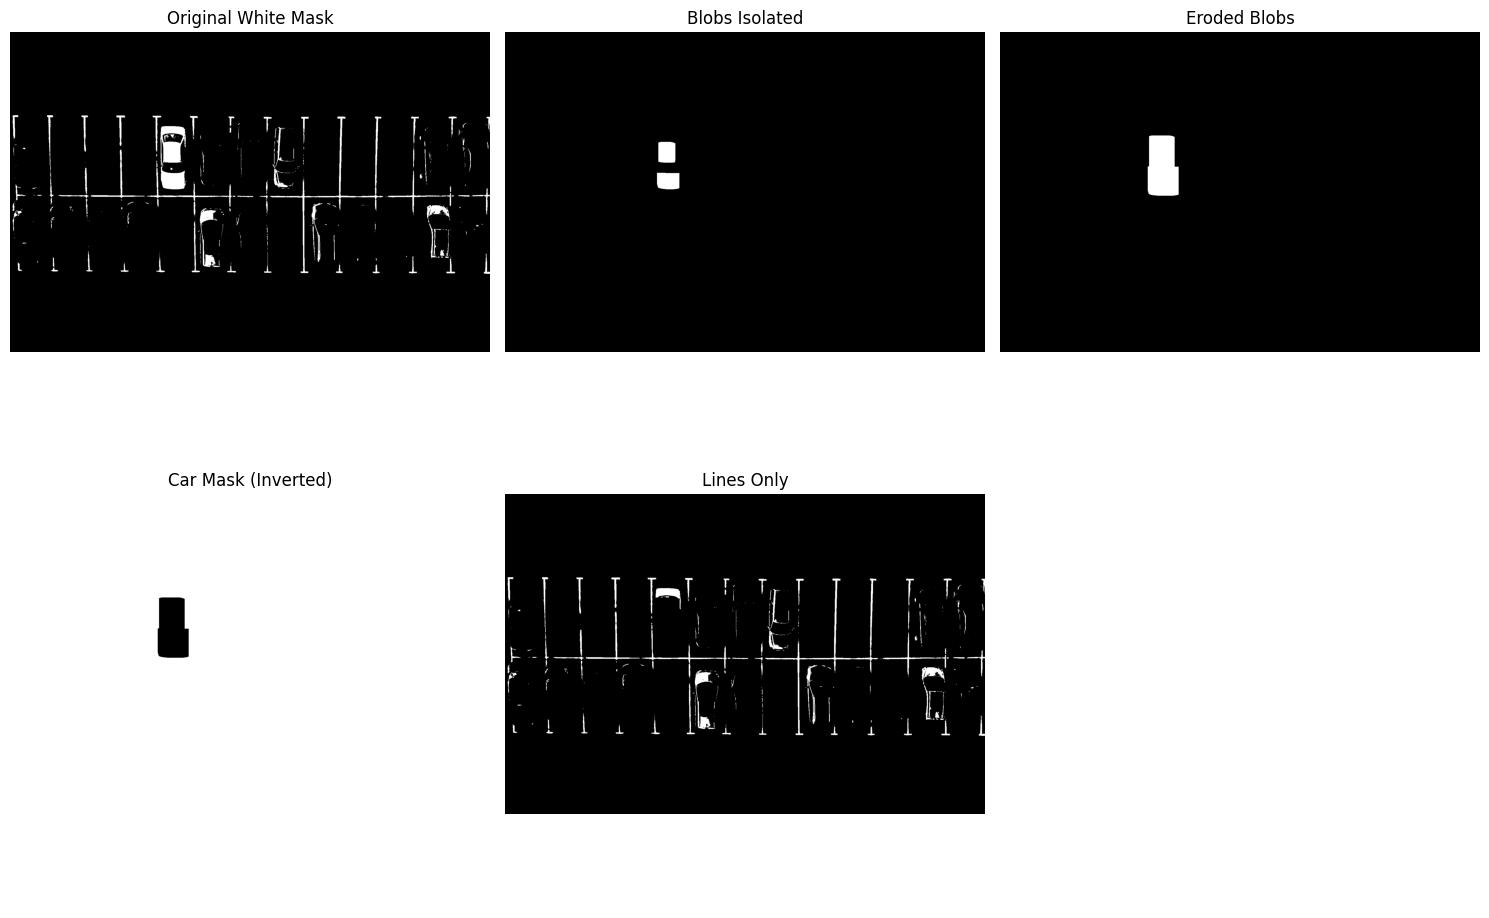

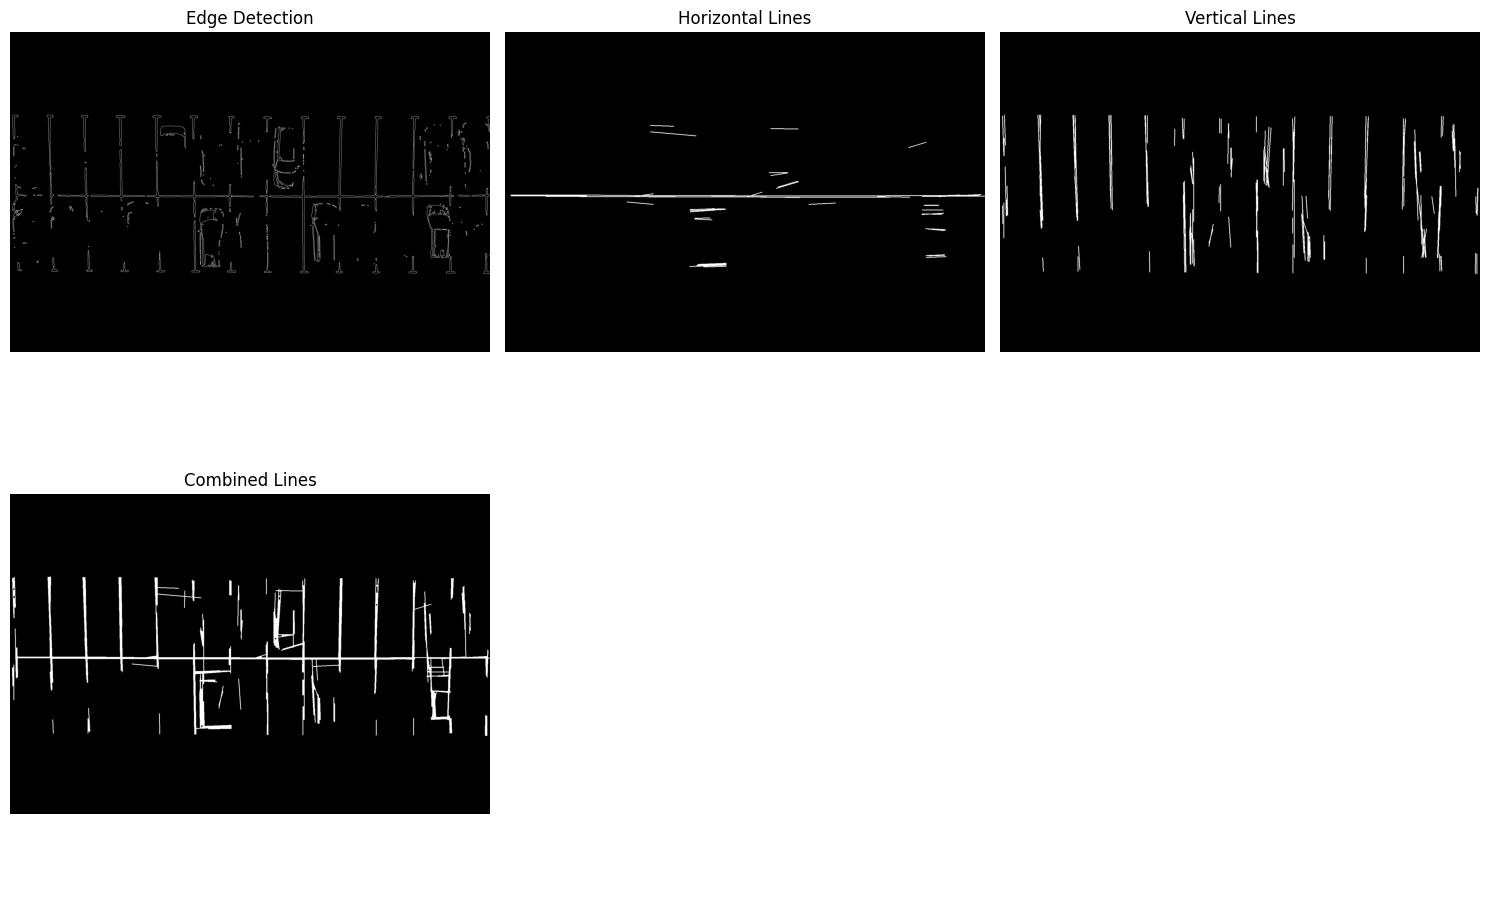

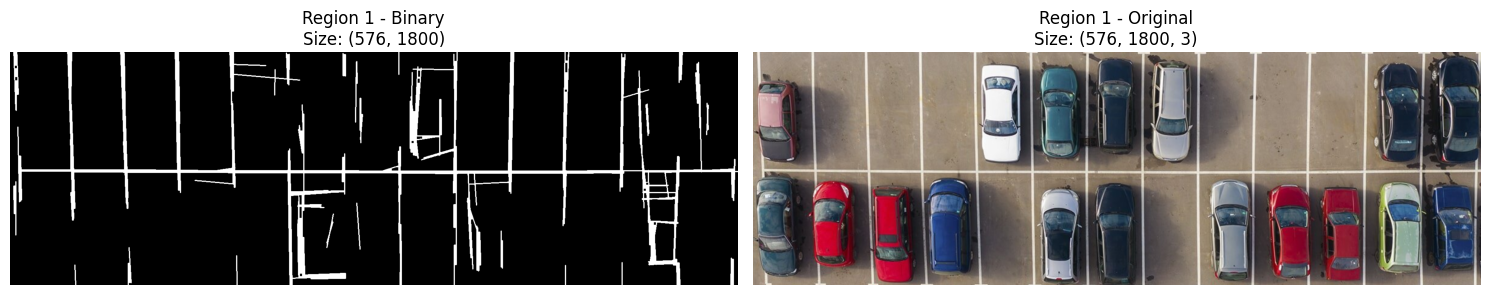

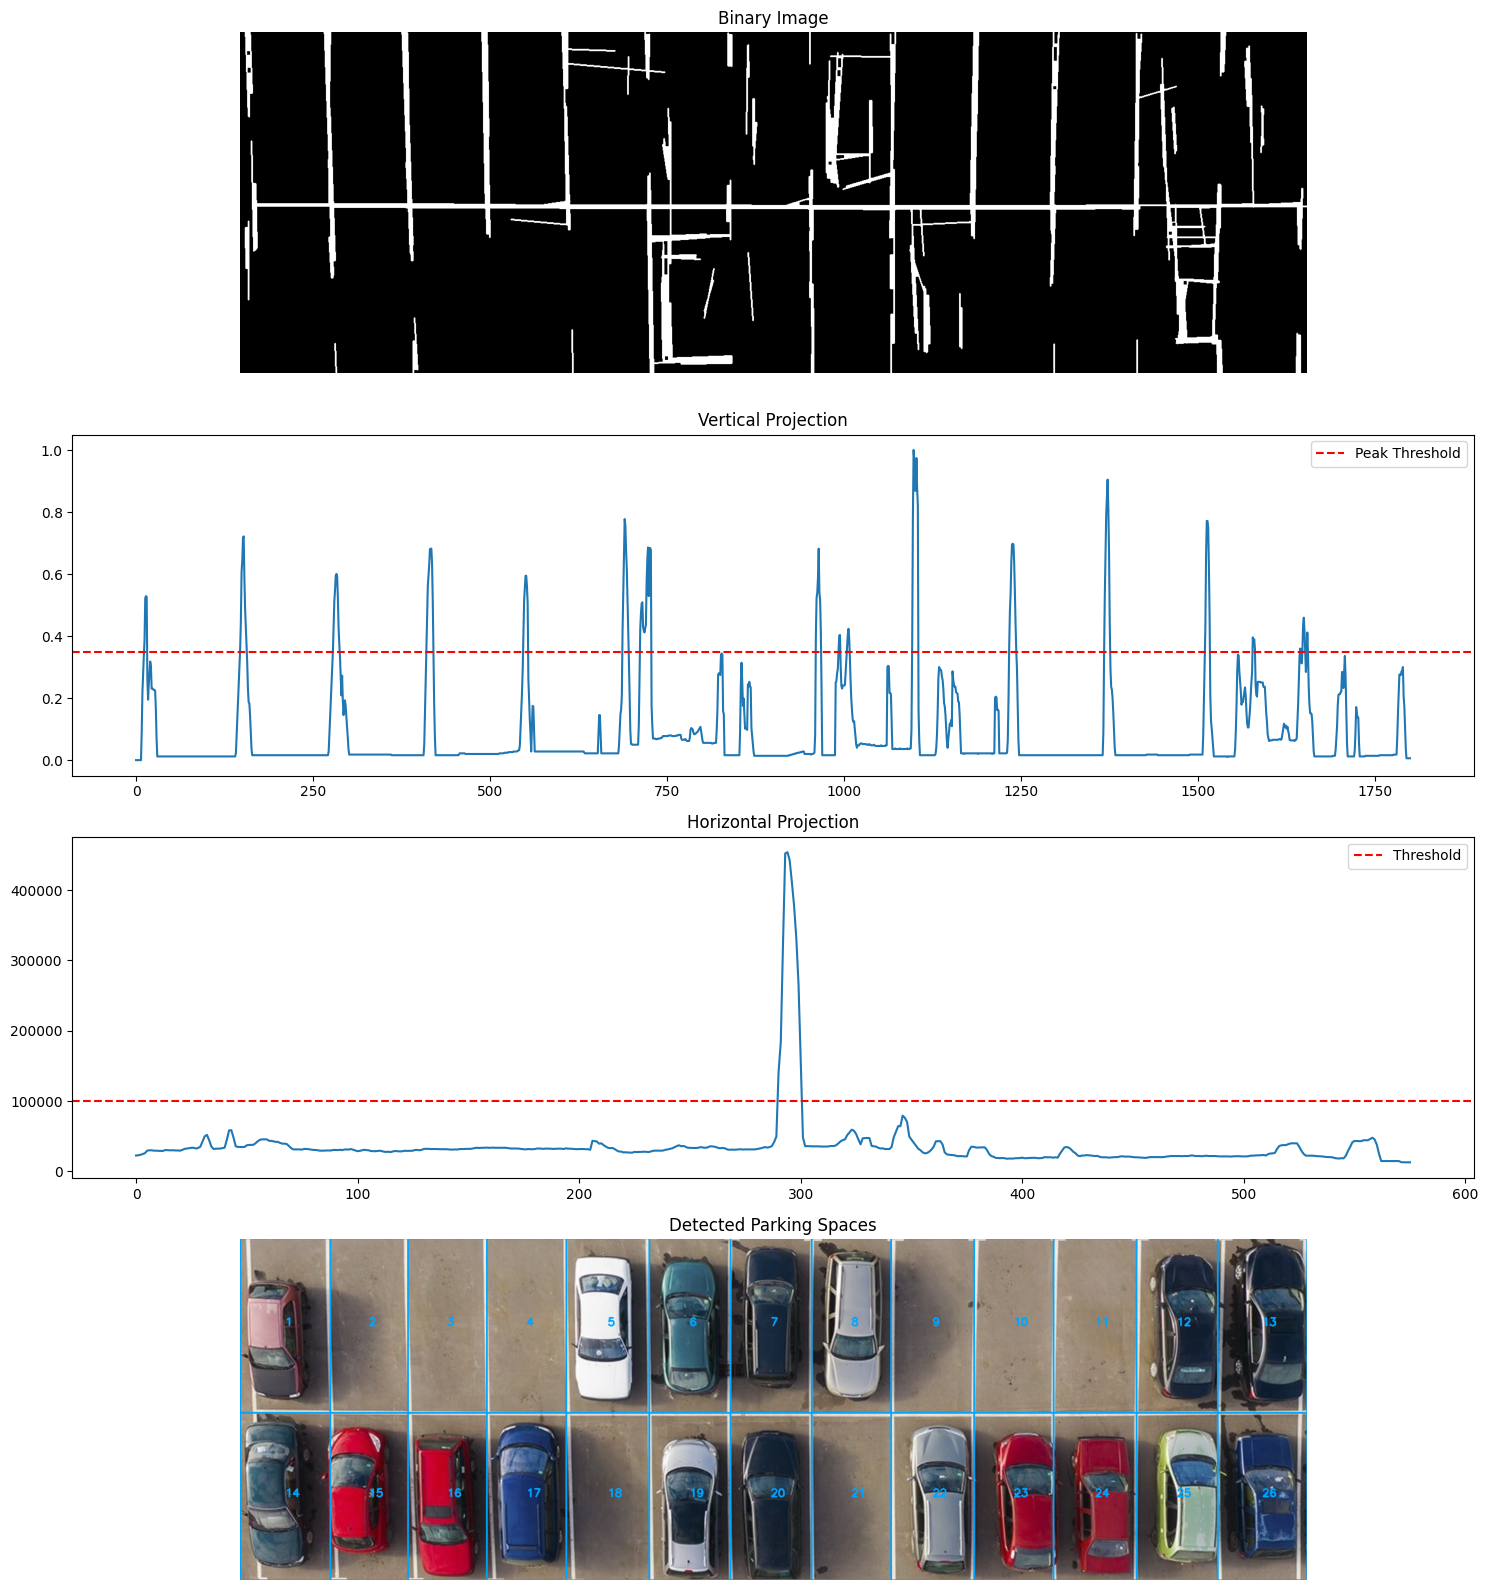

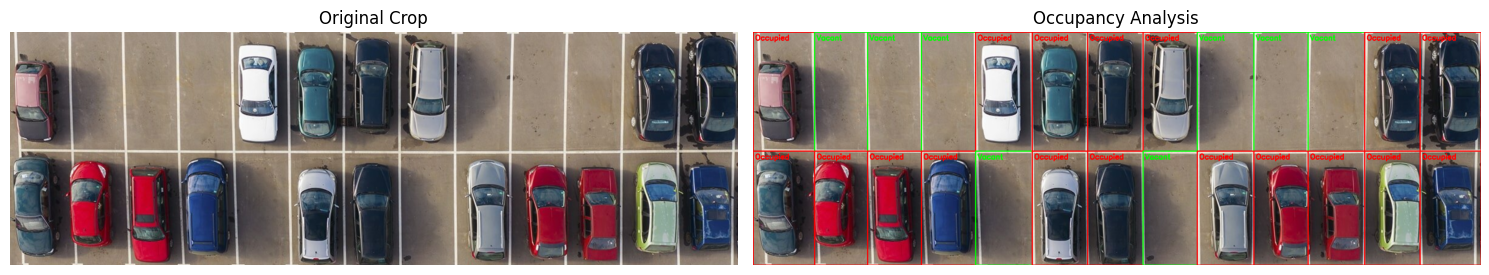

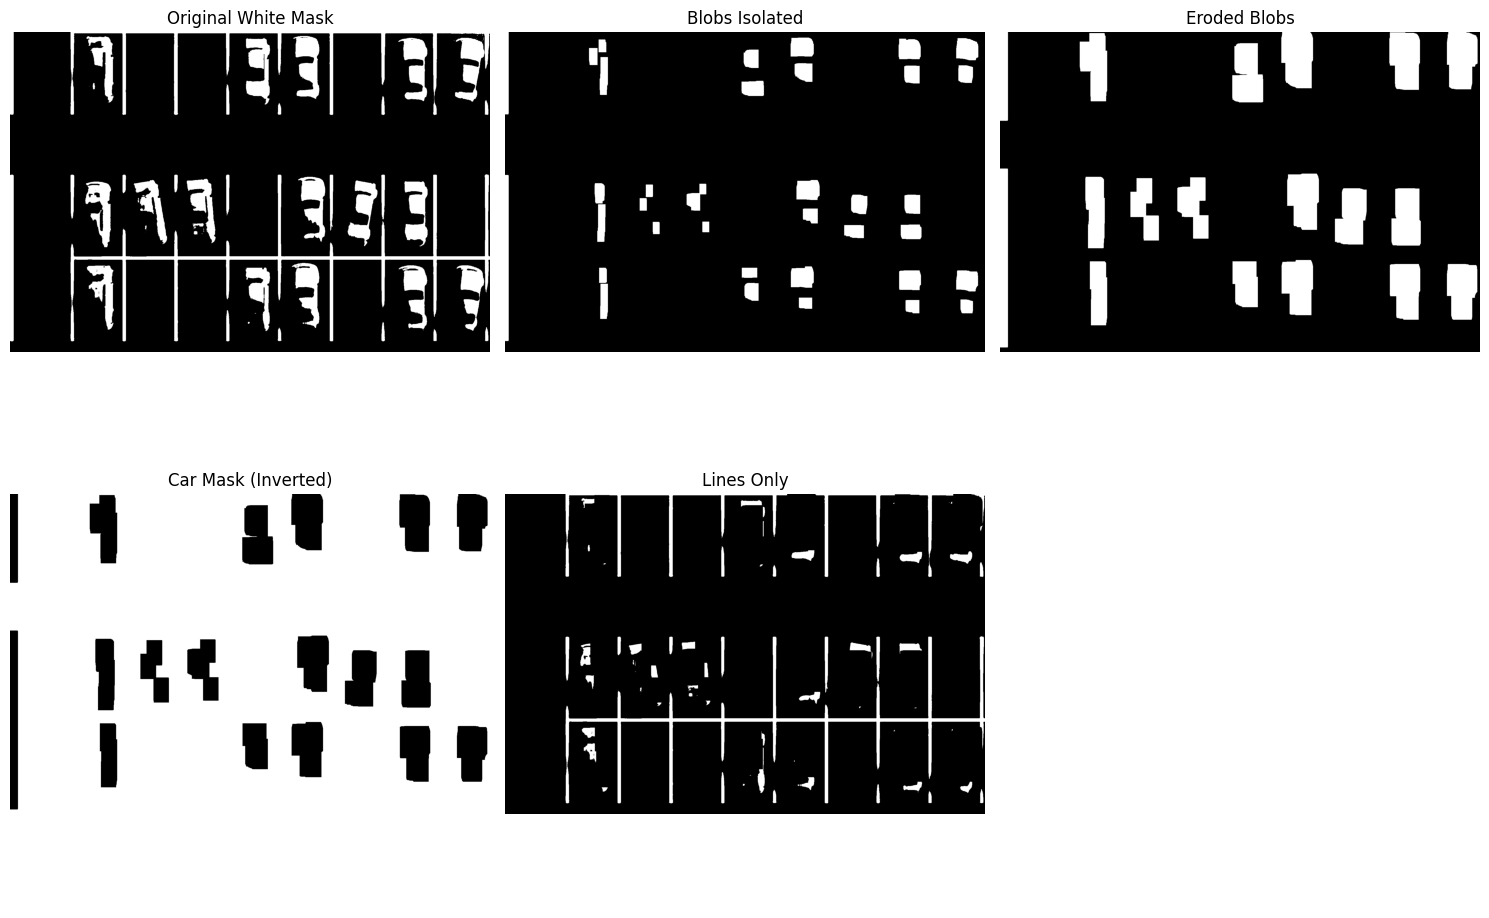

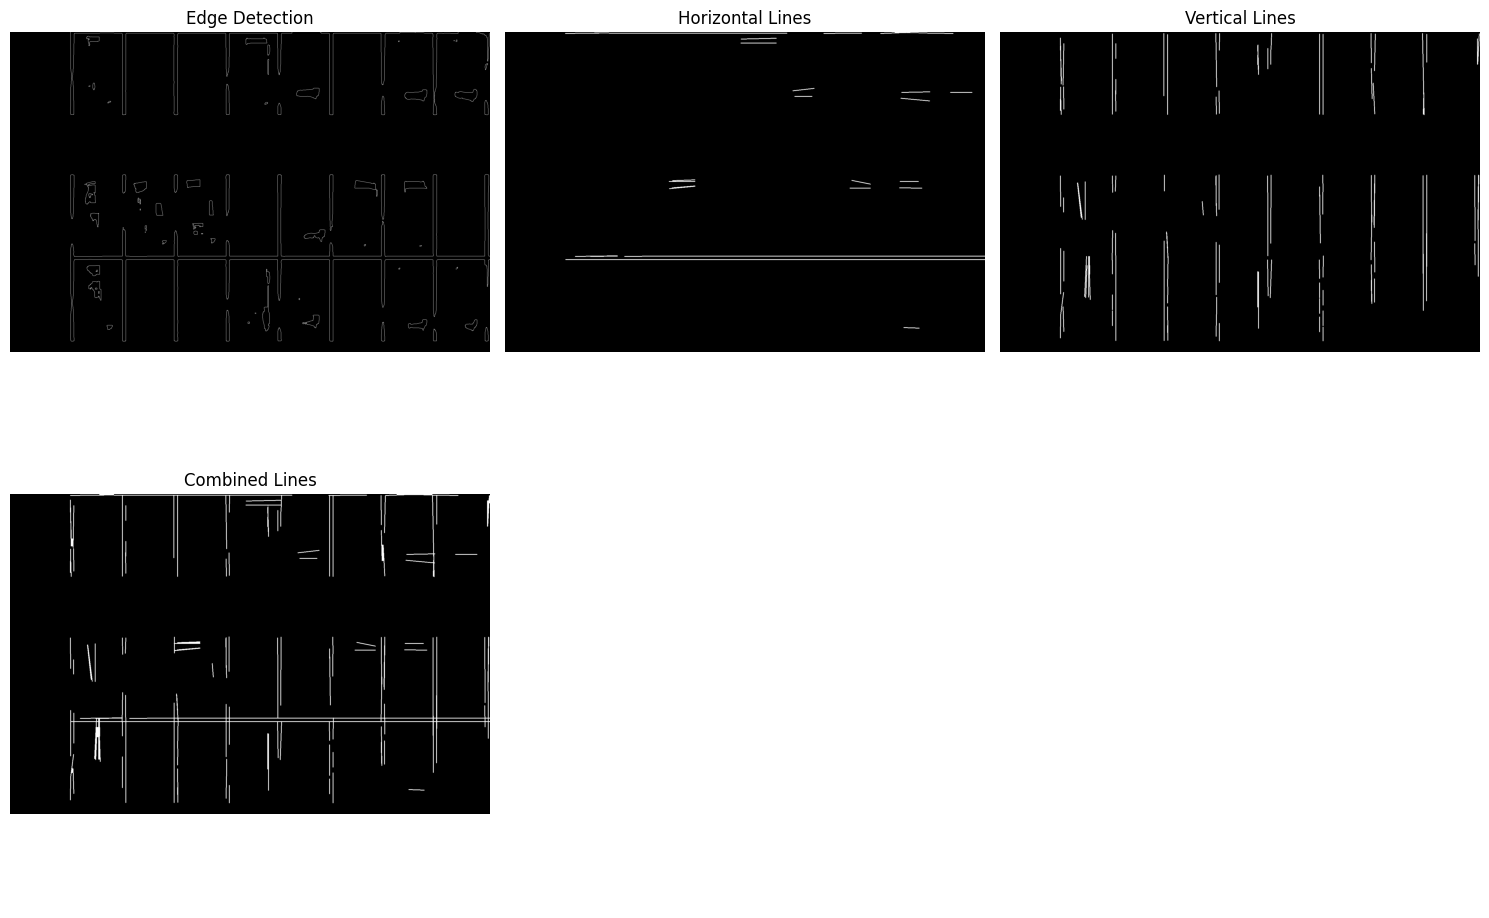

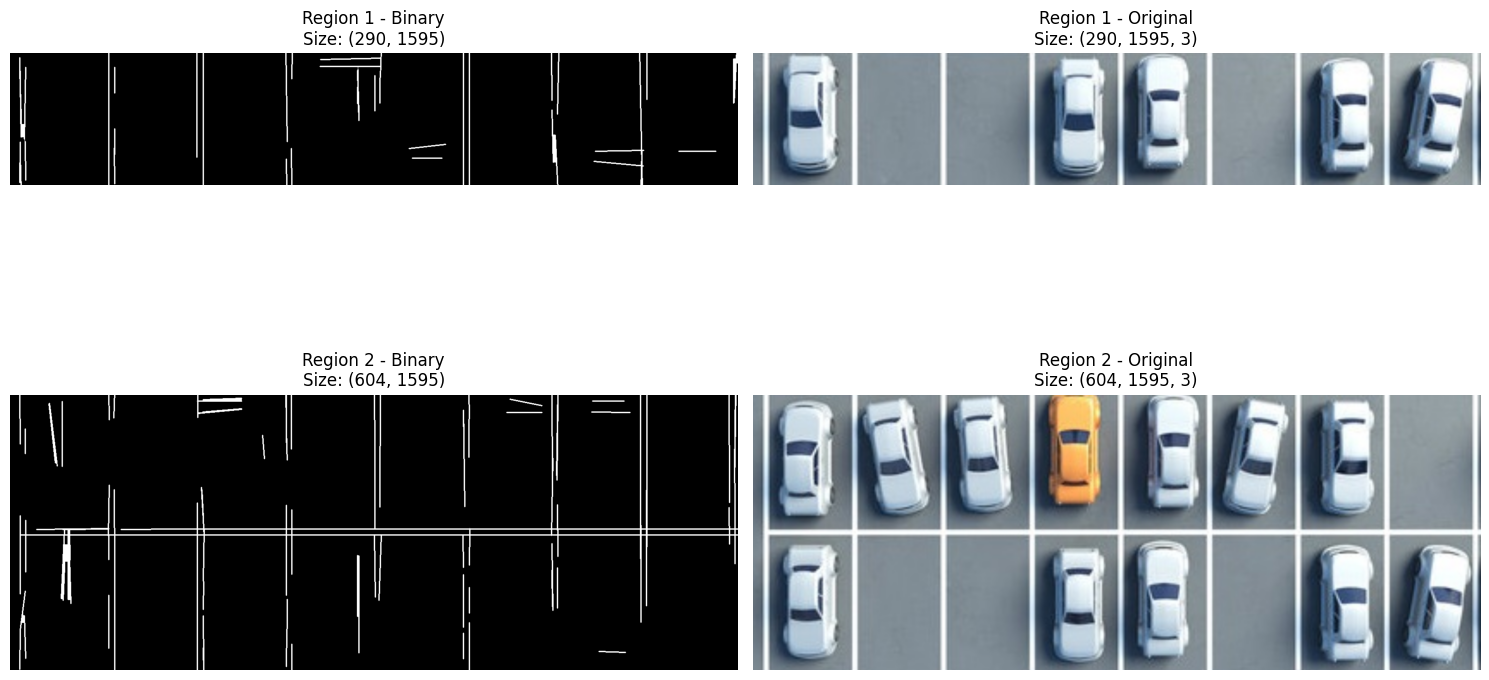

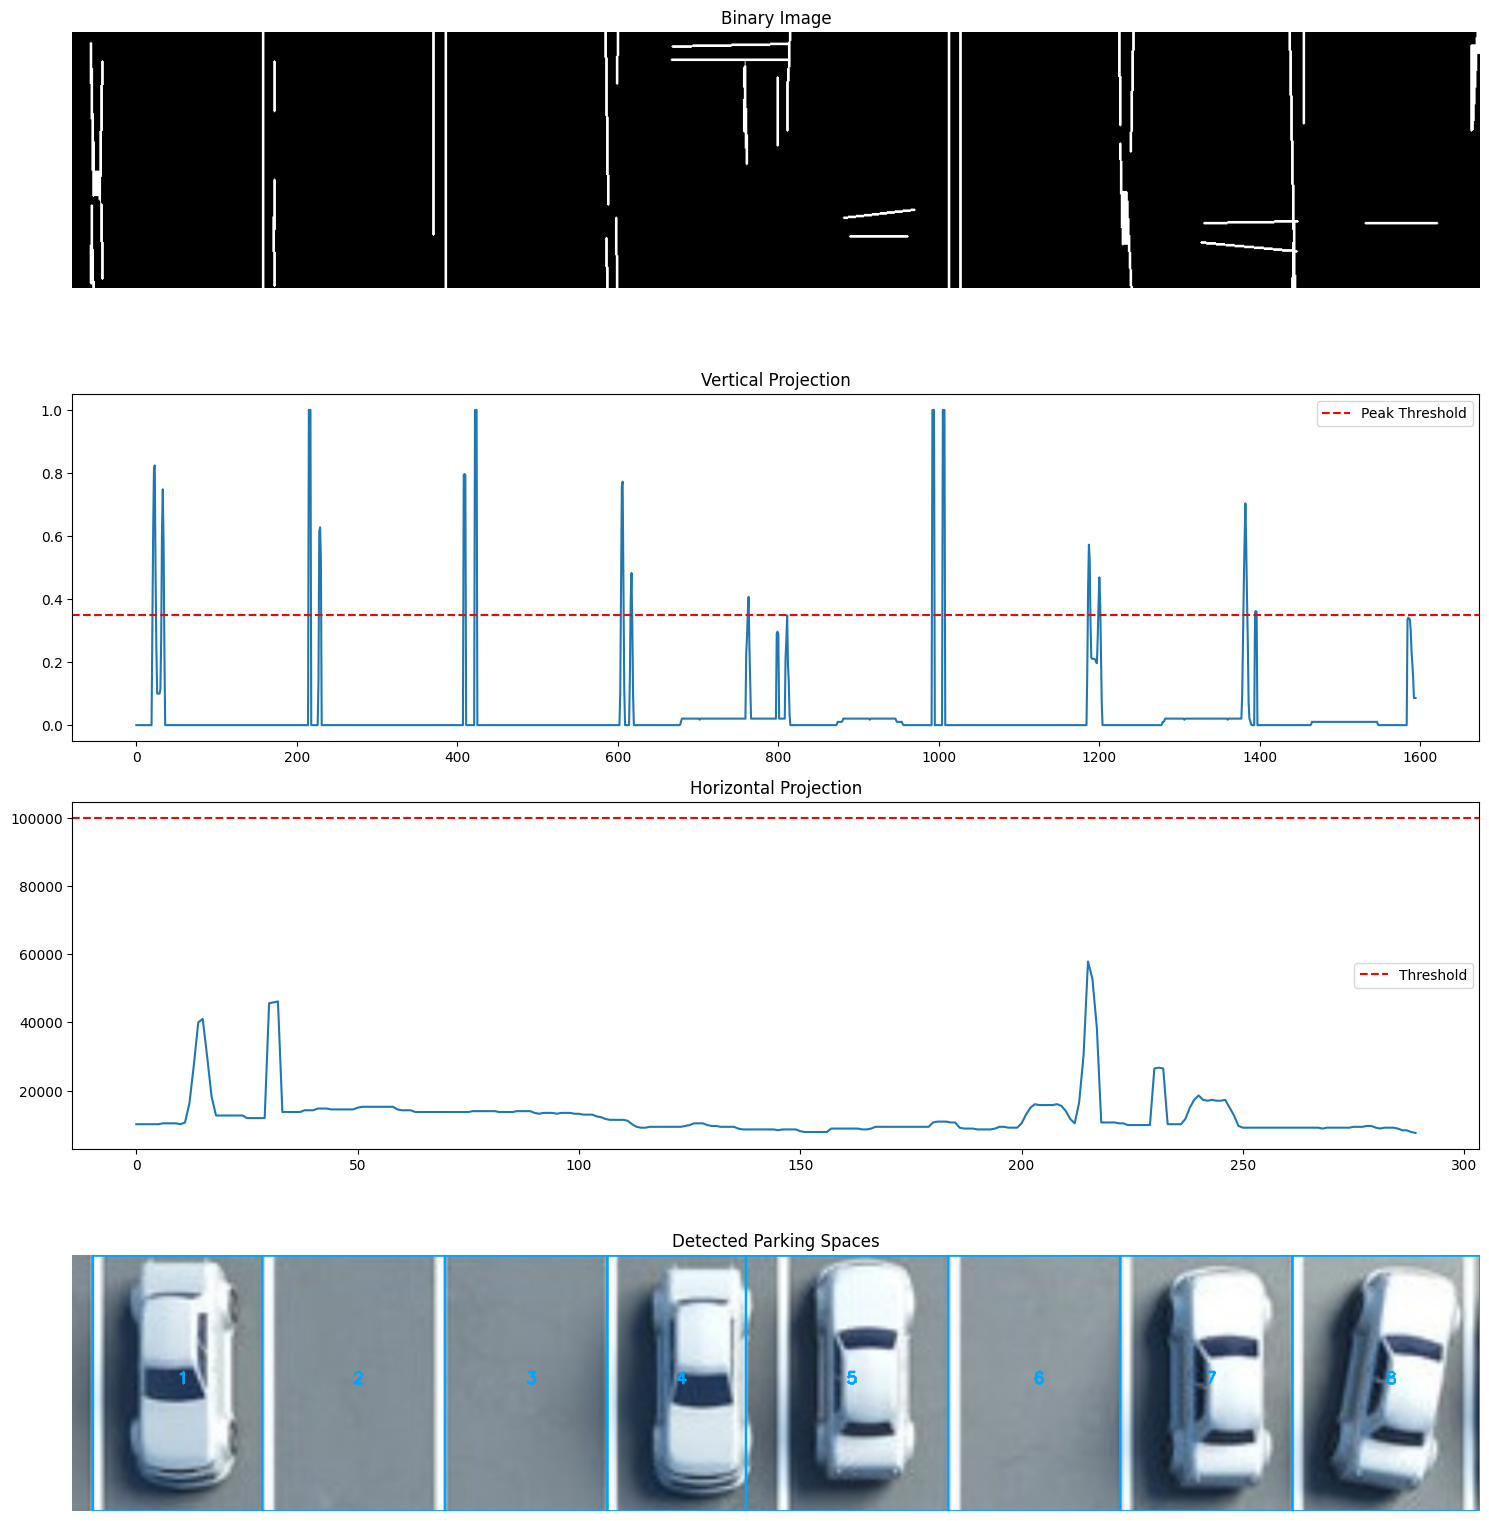

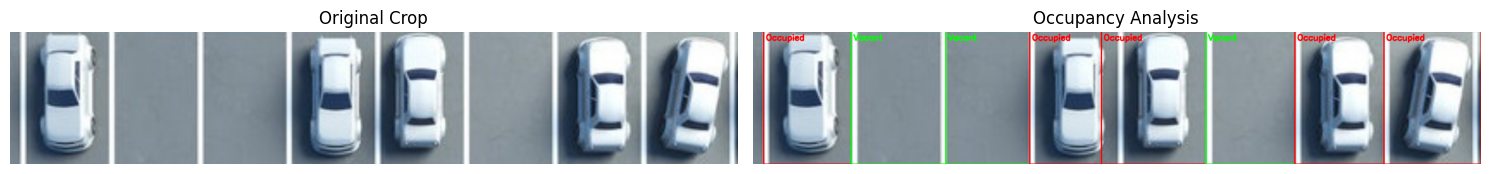

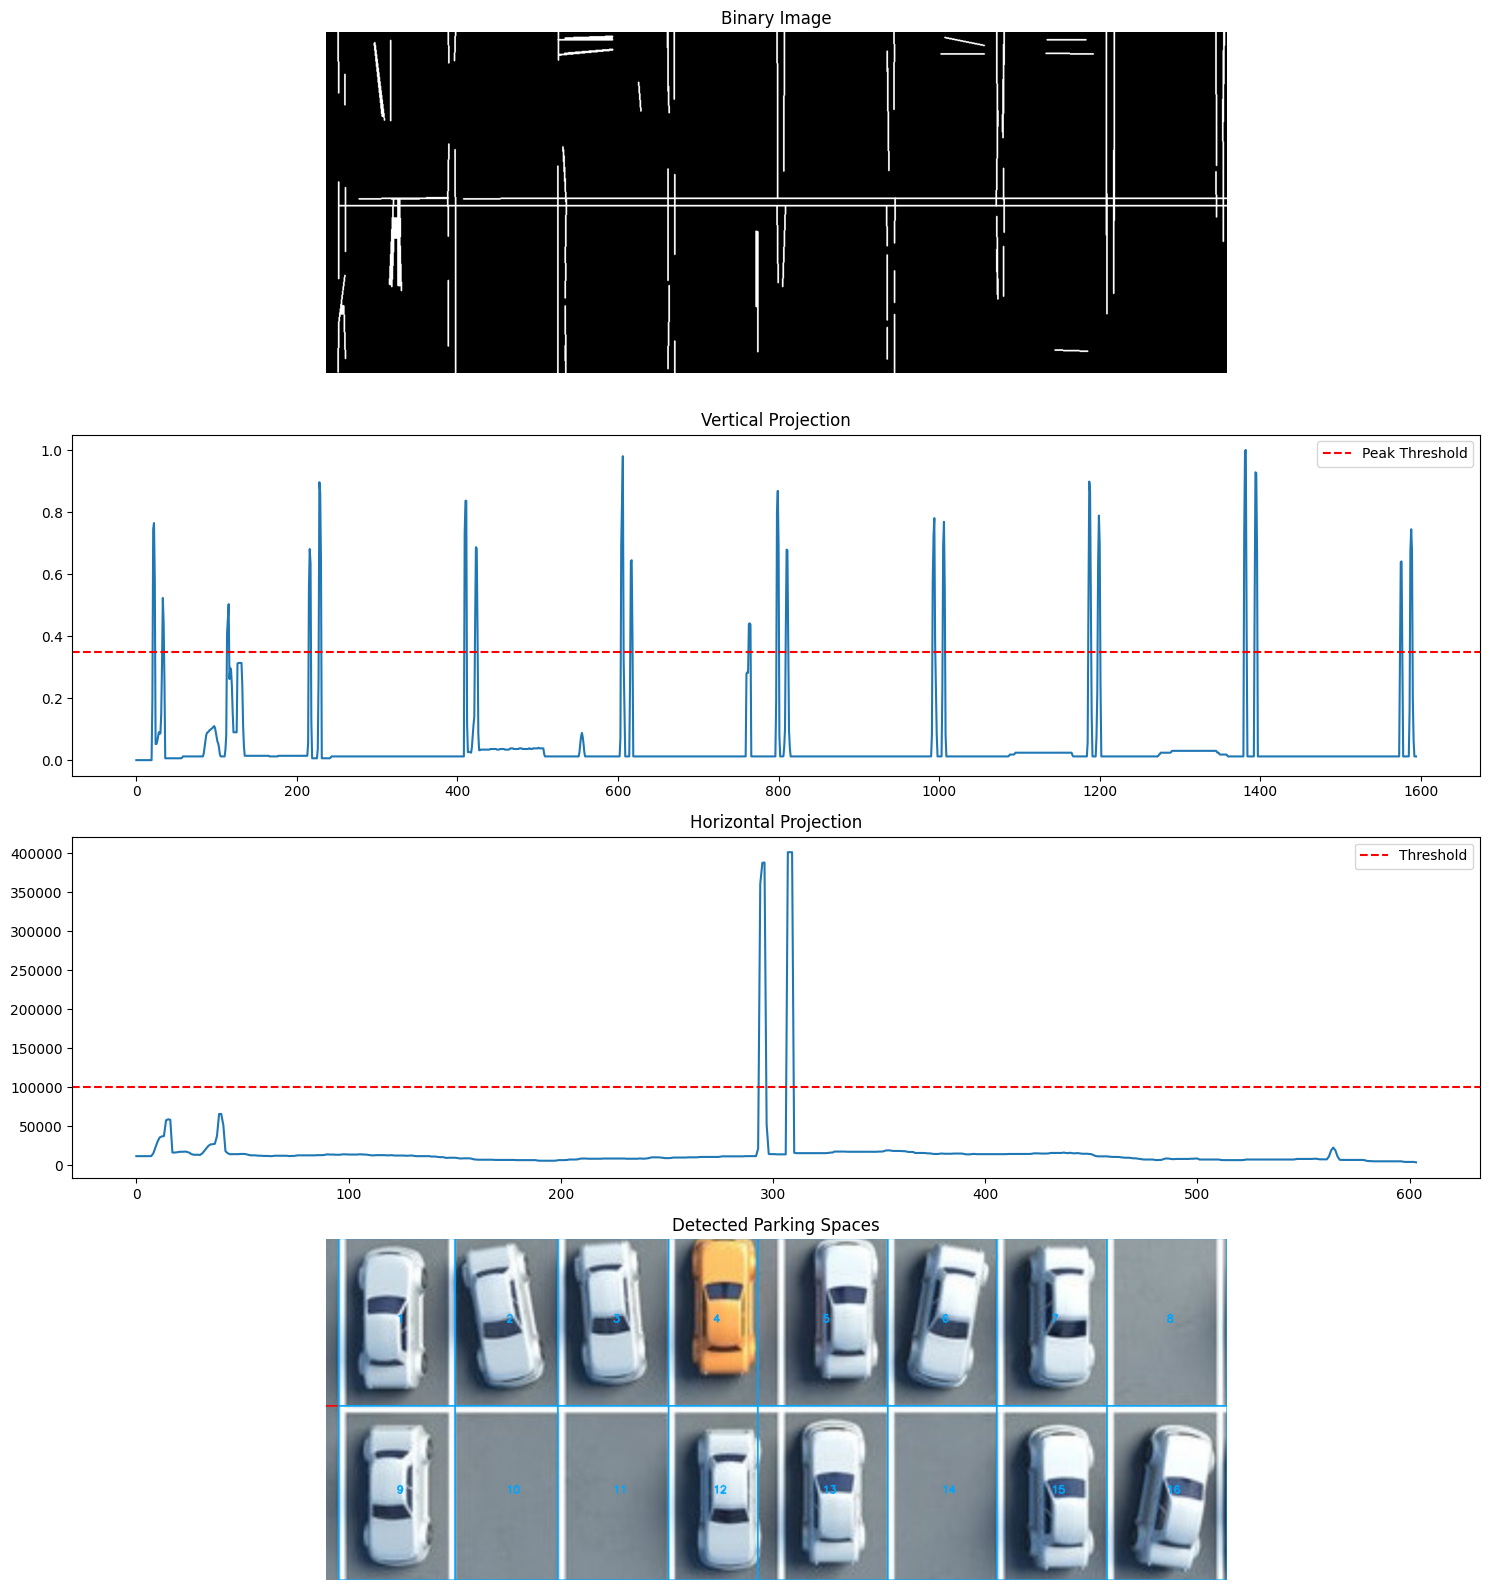

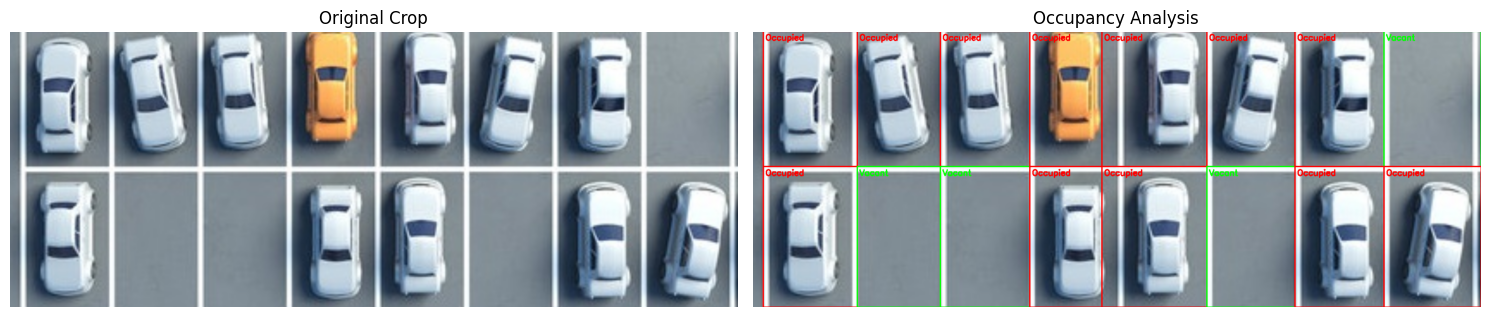

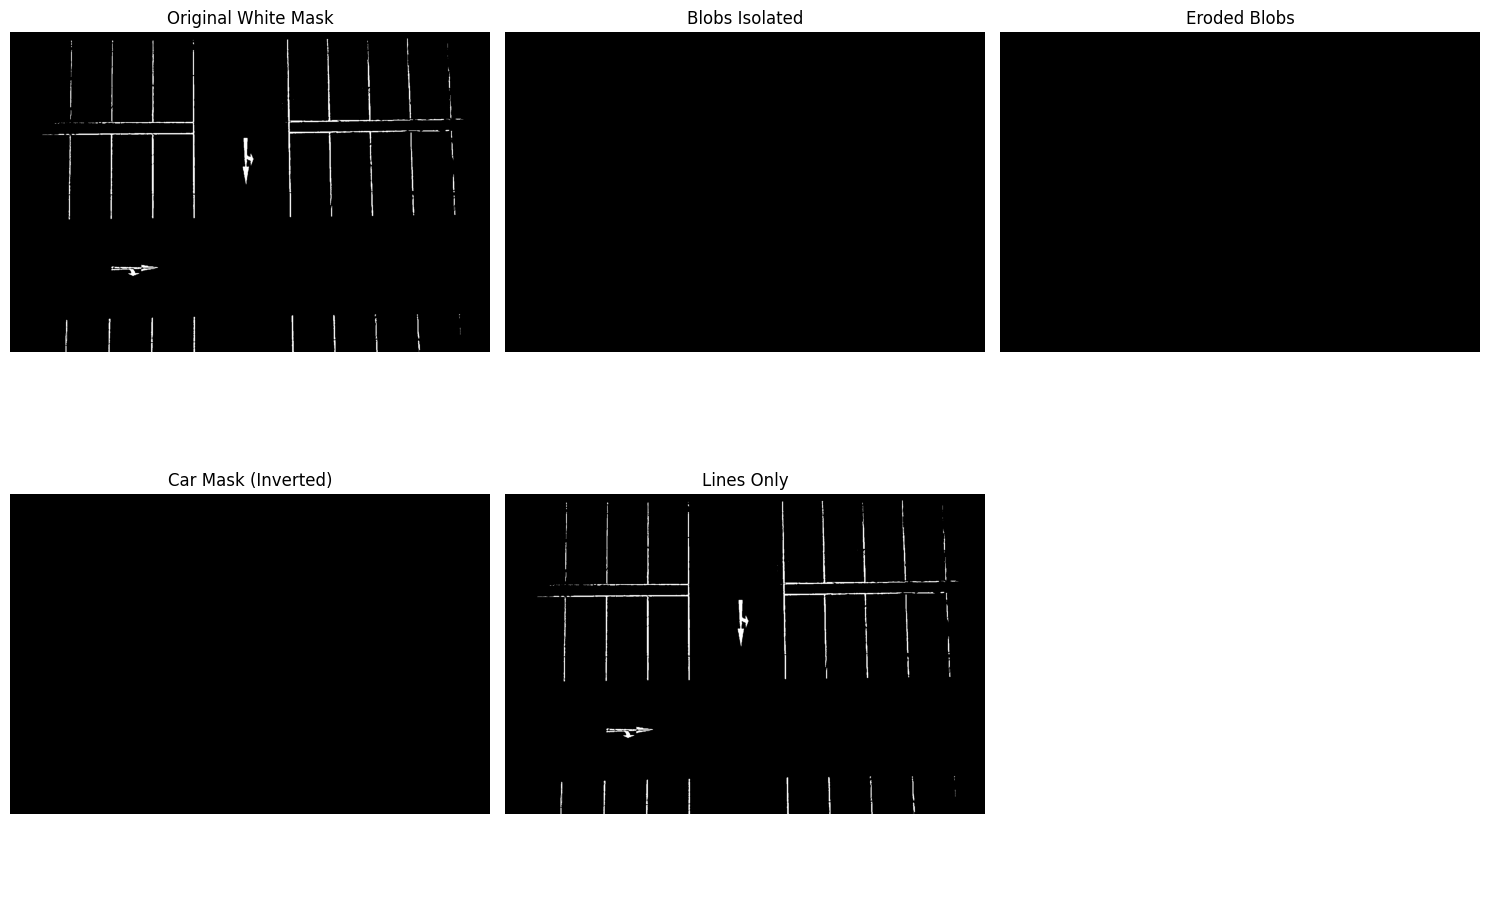

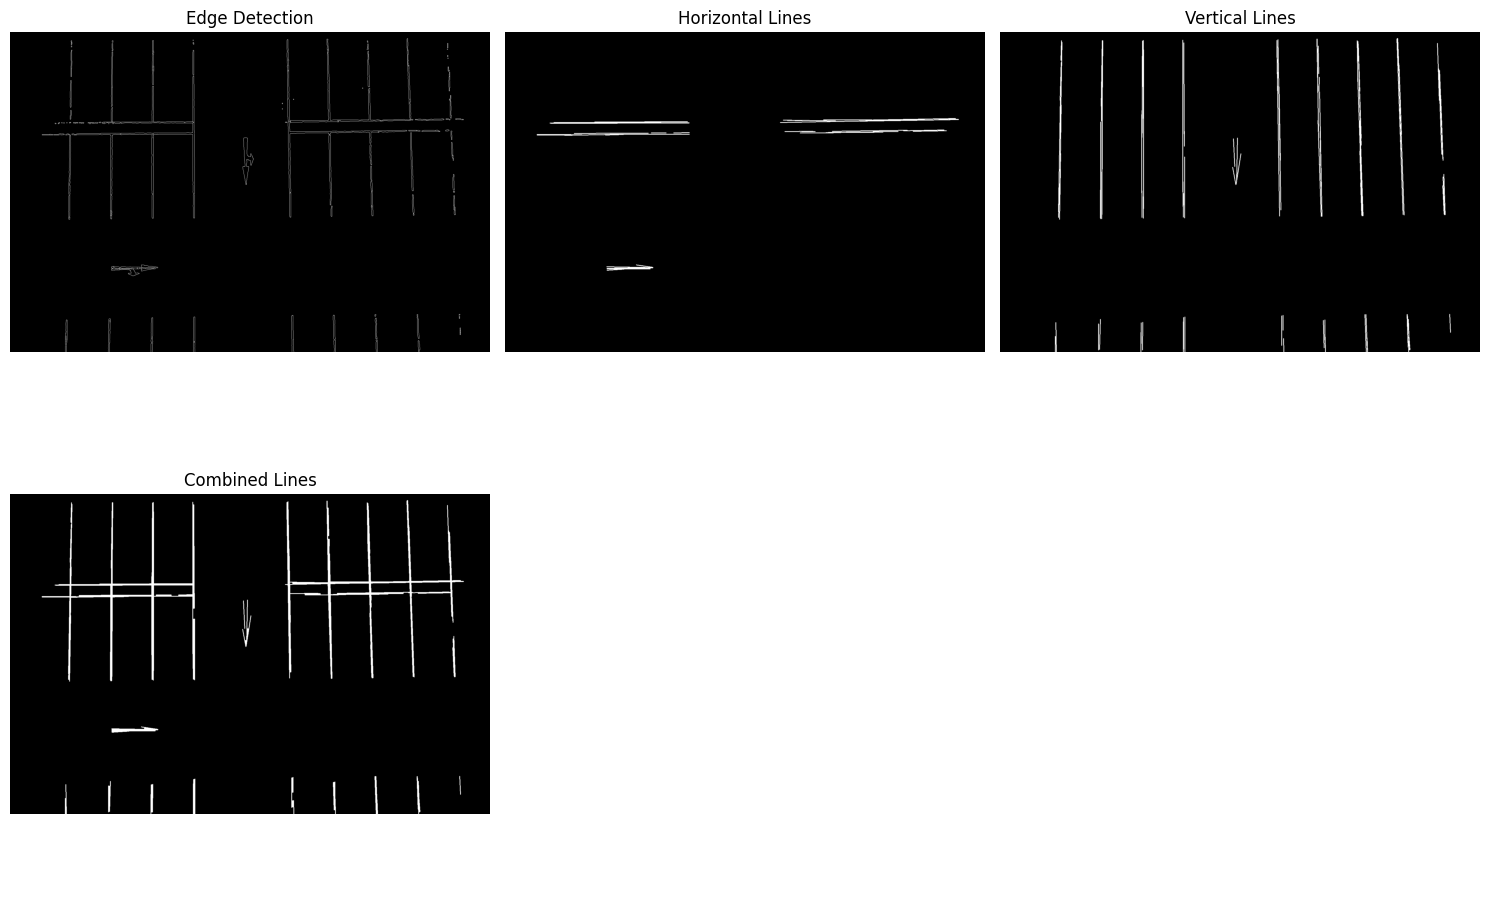

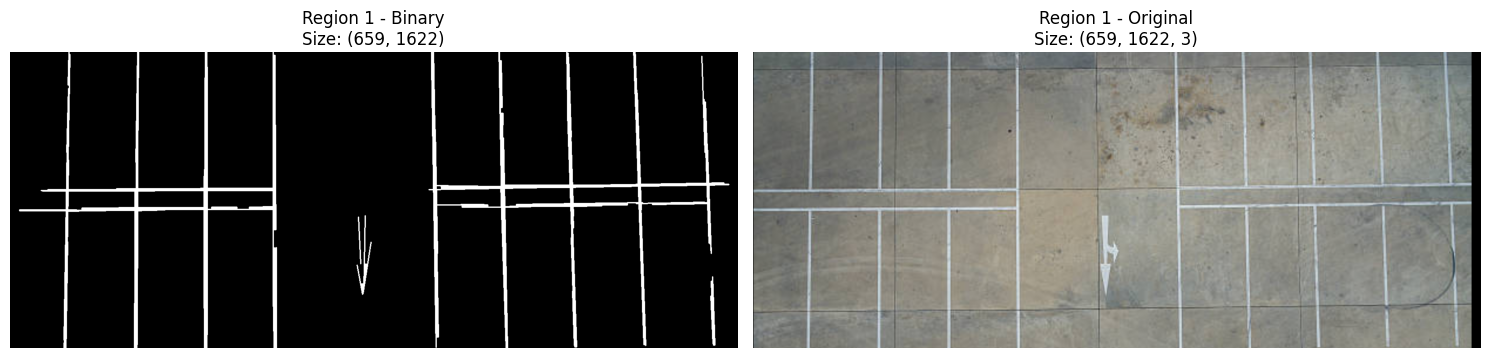

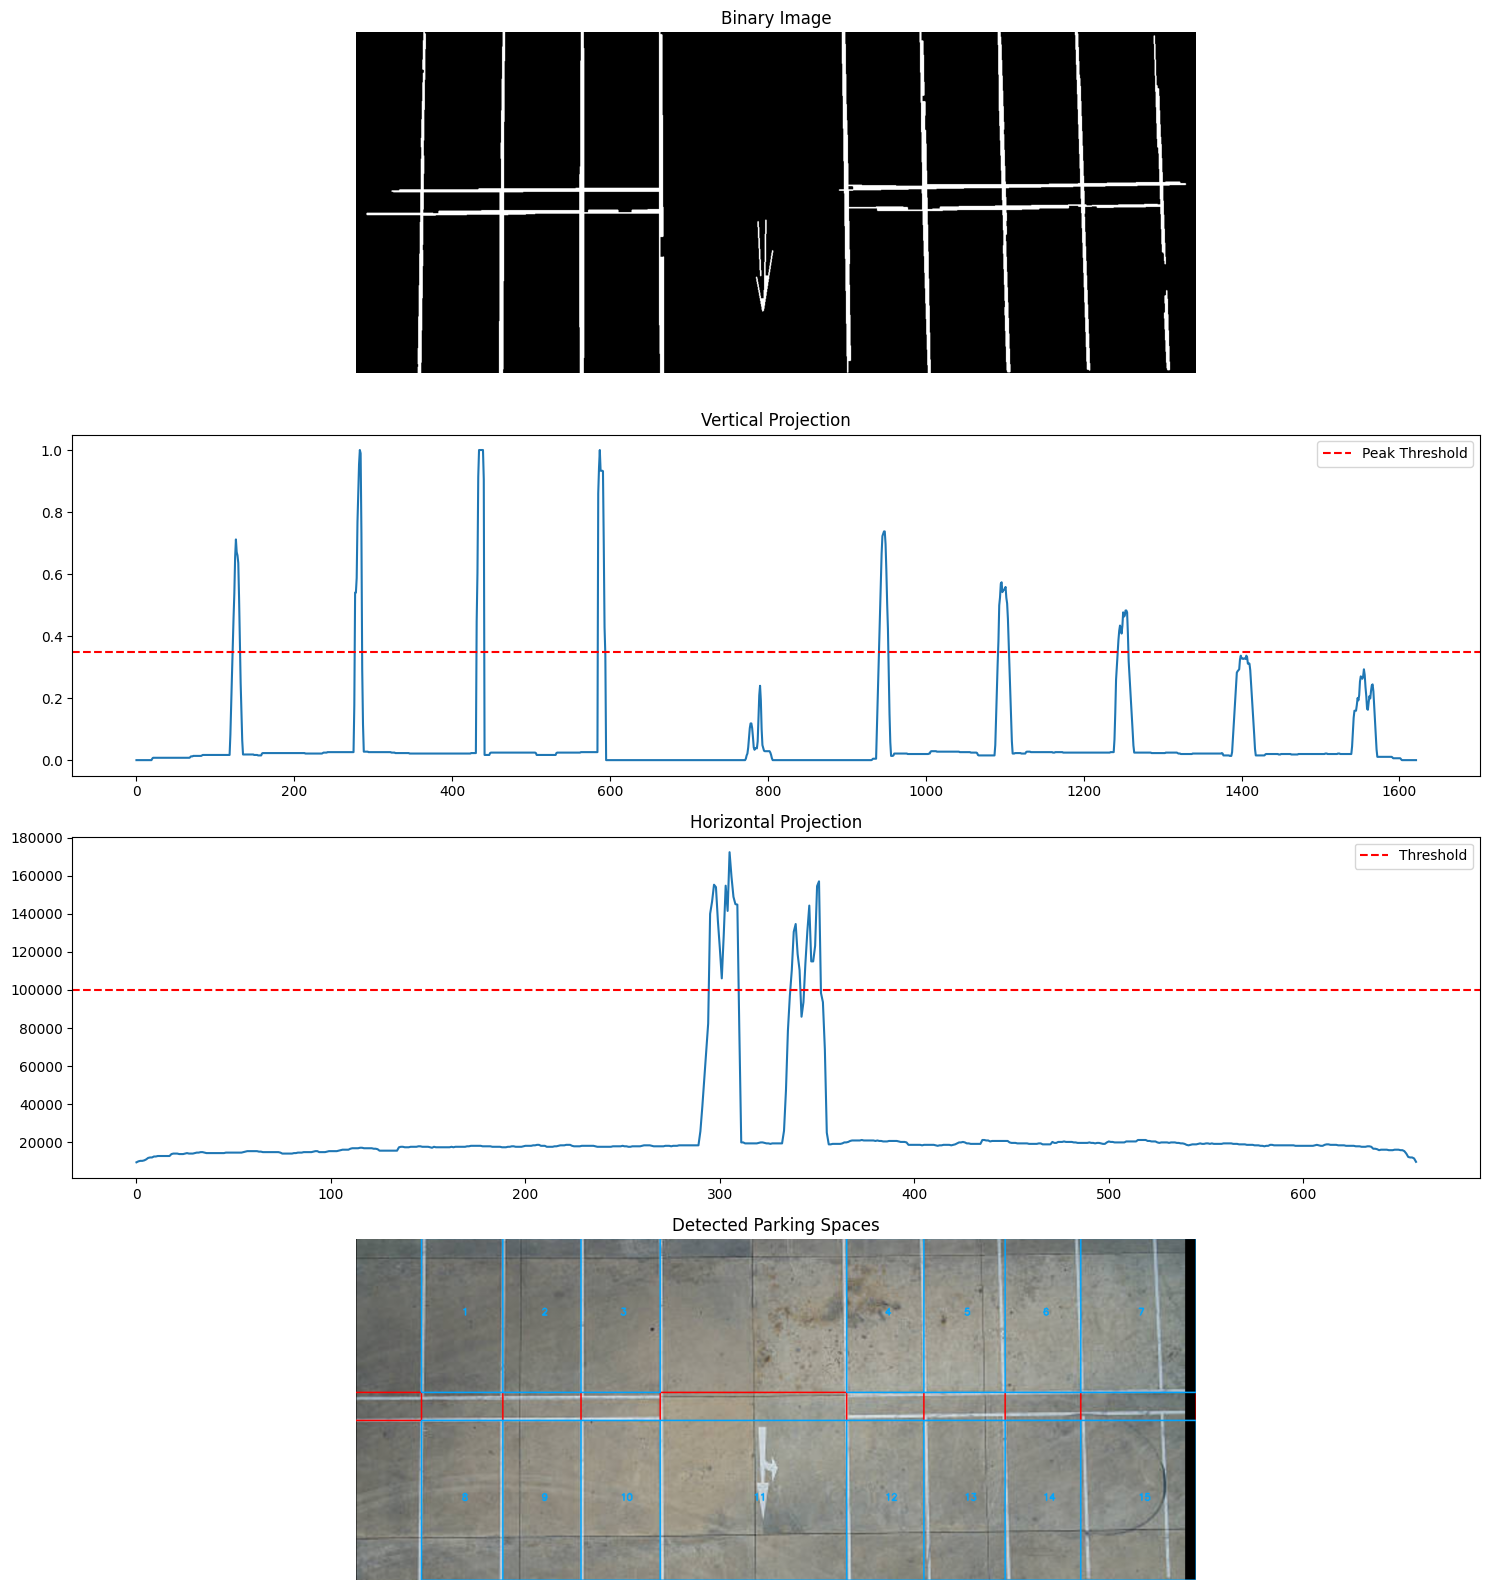

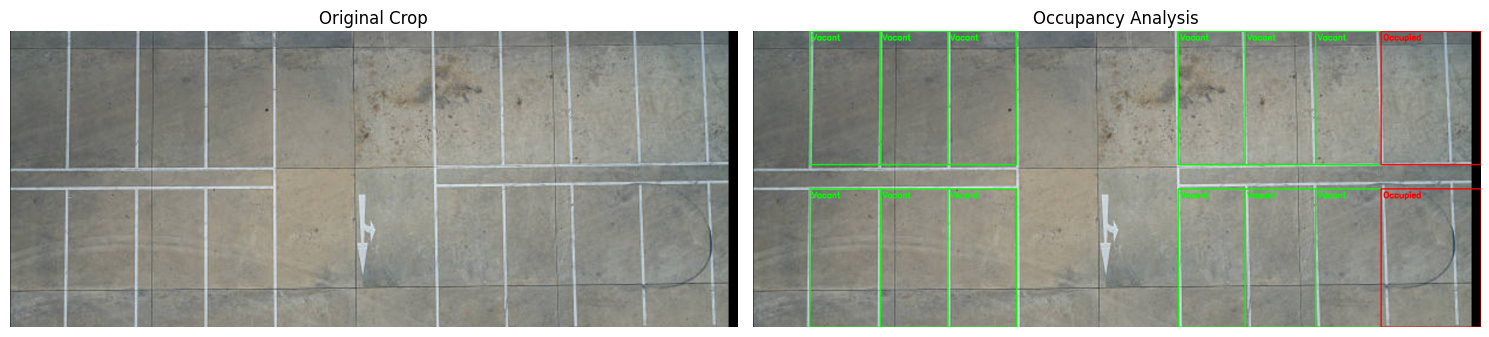

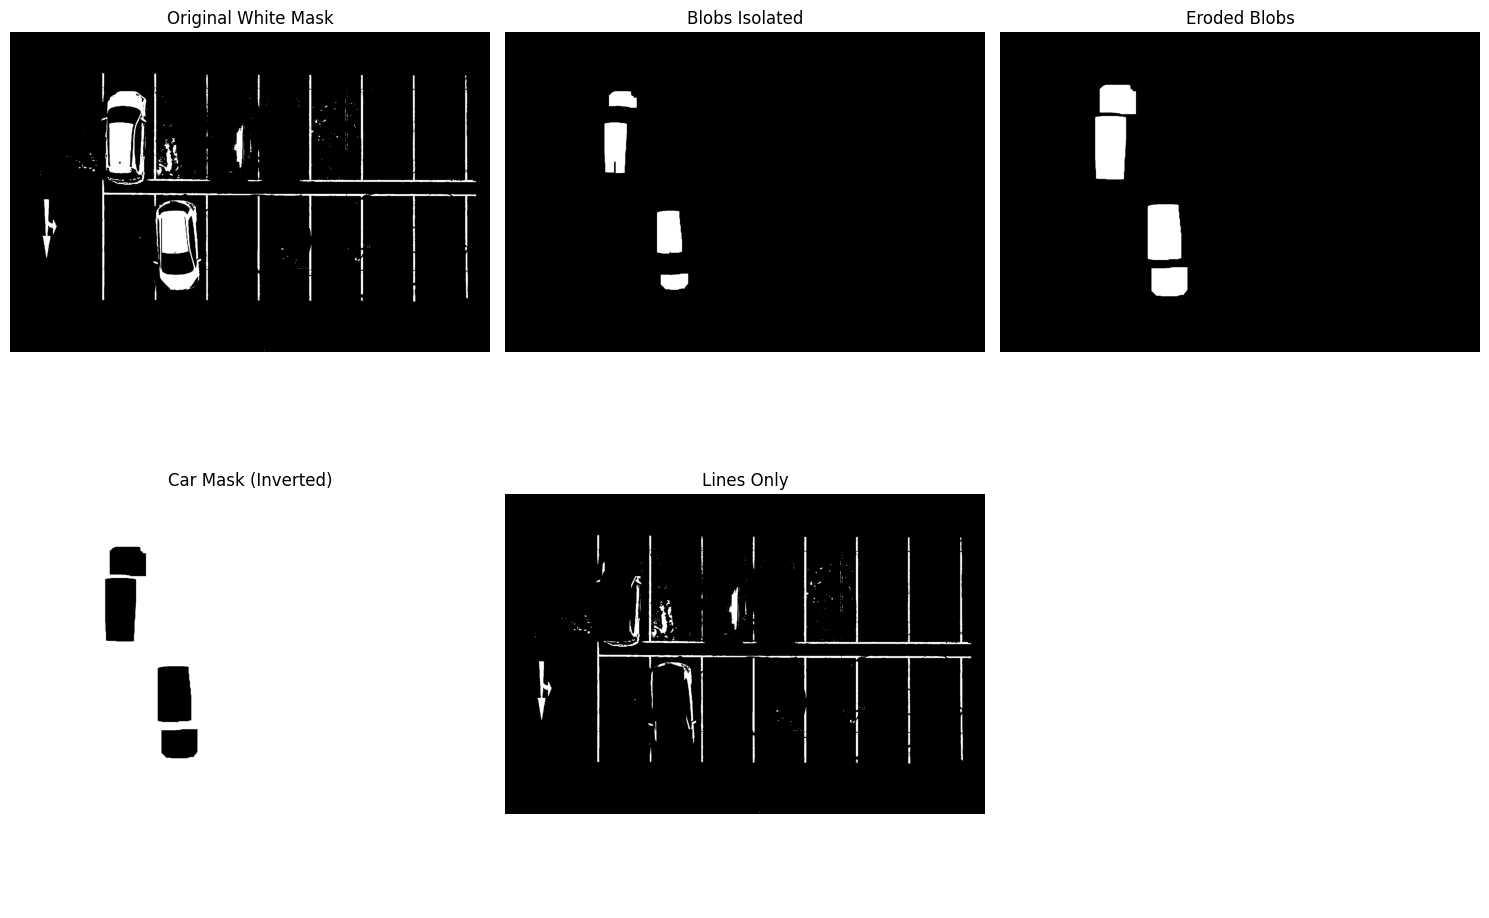

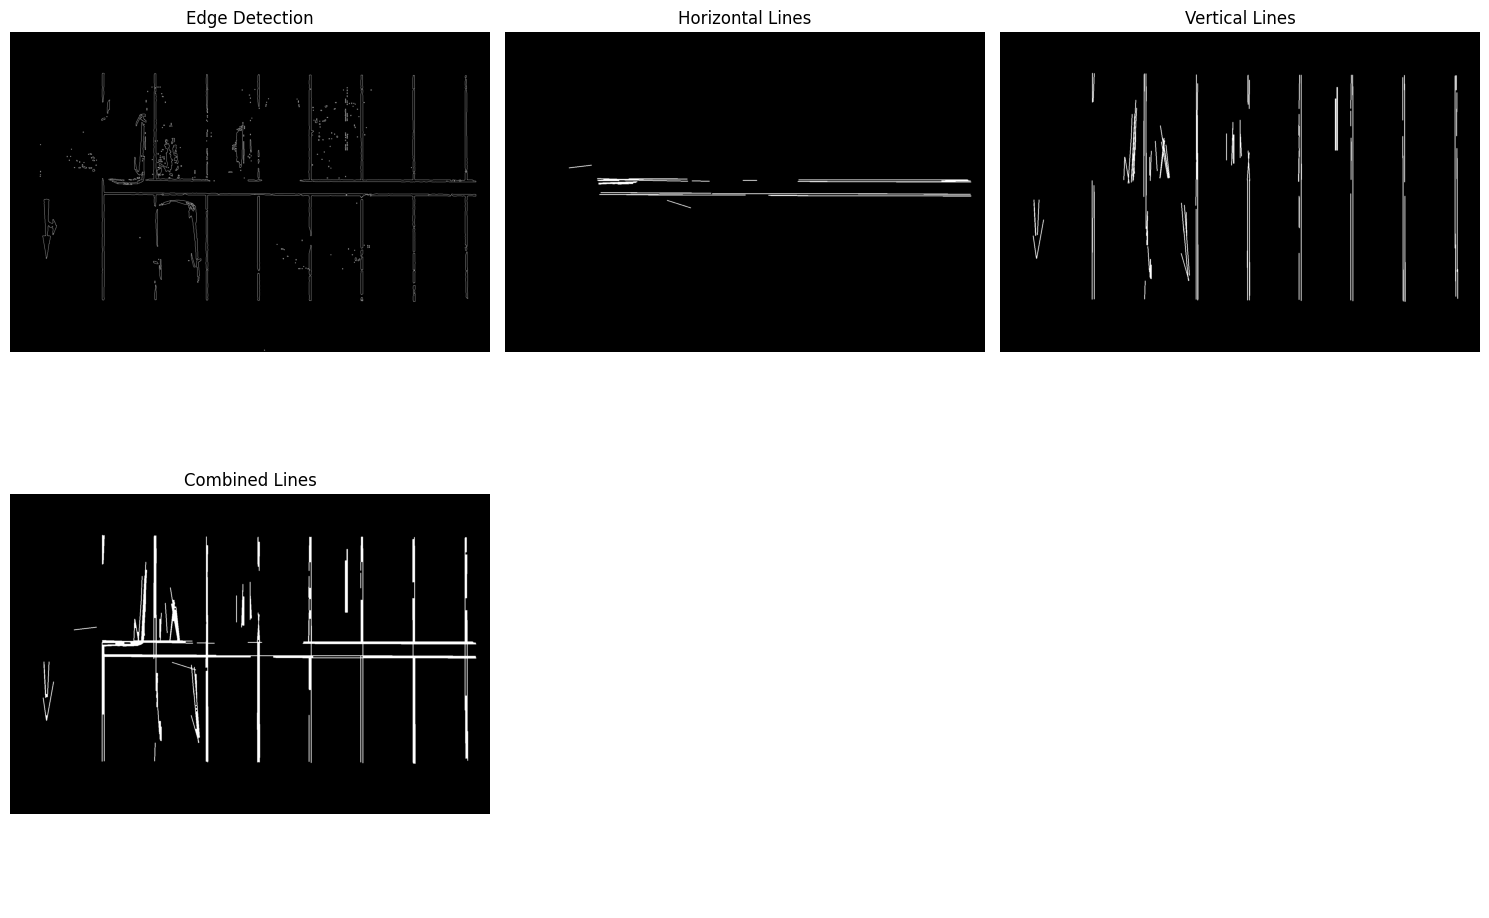

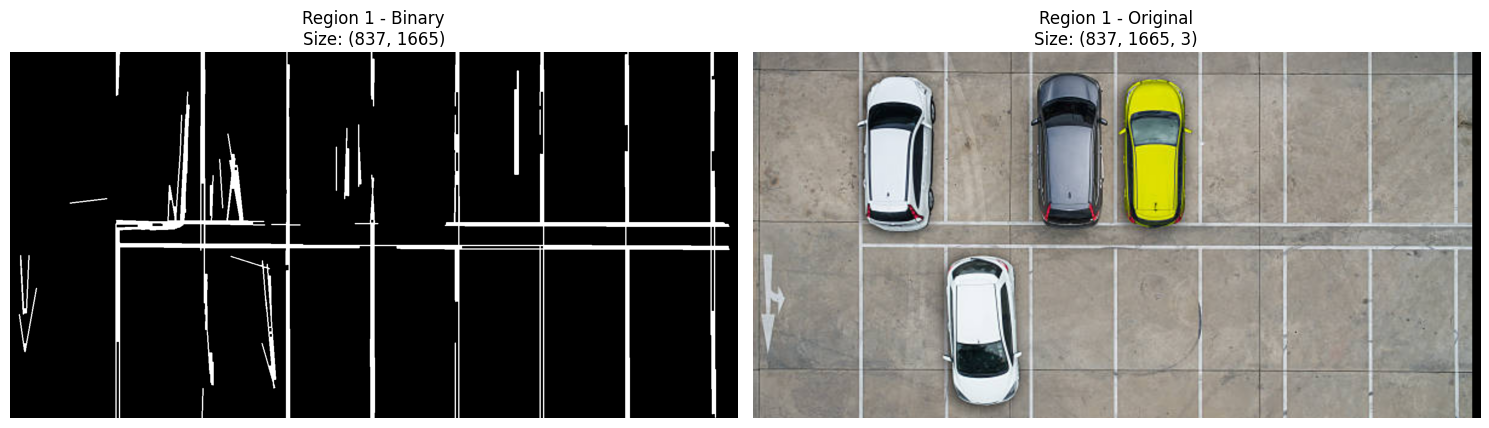

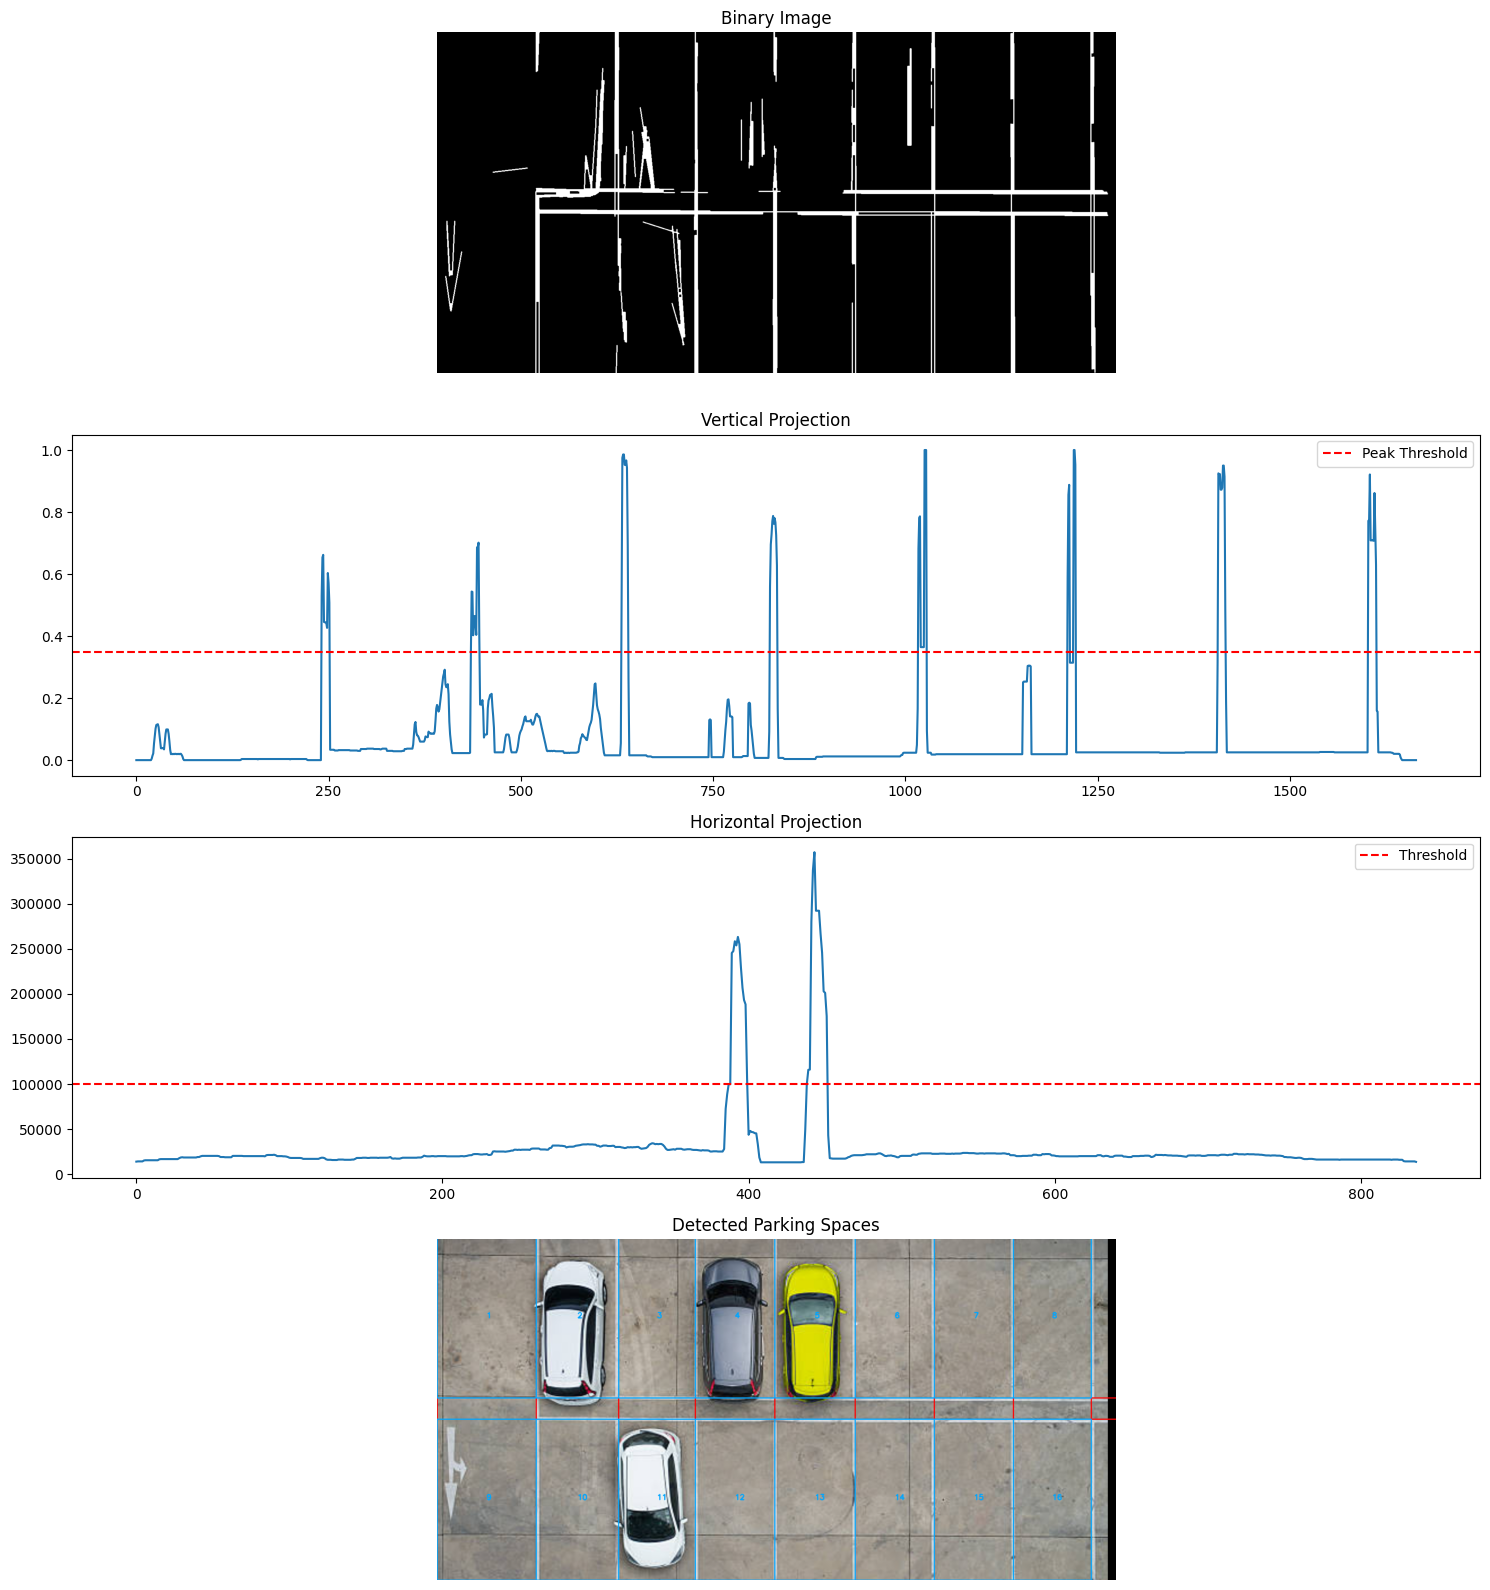

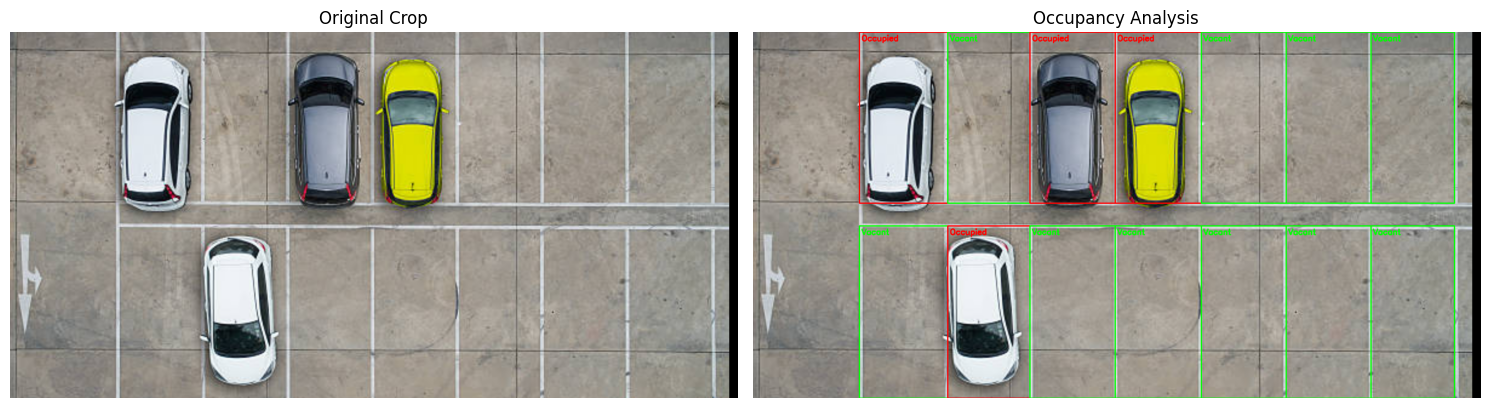

In [551]:
# Main processing loop
image_dir = 'c:/Users/Patrick/Documents/EmbeddedImageProcessing/Mini-Project/Mini_project_images/easy/*'
image_files = [file for file in glob(image_dir, recursive=True) if file.endswith(('.jpg', '.png'))]
all_results = []    

for i, file in enumerate(image_files):
    original_img = cv2.imread(file)
    standardized = standardize_image(original_img)
    parking_spaces = detect_white_lines(standardized)
    parking_lines = detect_parking_lines(parking_spaces)
    binary_crops, original_crops, crop_coordinates = crop_parking_regions(parking_lines, standardized)


    for binary_crop, original_crop in zip(binary_crops, original_crops):
        v_peaks, h_peaks, _  = detect_parking_spaces(binary_crop, original_crop)
        spots = extract_parking_spots(original_crop, v_peaks, h_peaks)
        cv2.waitKey(1000)
        occupancy_results, annotated_img = analyze_parking_spot_occupancy(original_crop, spots)
        all_results.extend(occupancy_results)